# 물류 유통량 예측 경진대회

대회 사이트 : https://dacon.io/competitions/official/235867/overview/description

# 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/DACON/물류 유통량 예측 경진대회/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/DACON/물류 유통량 예측 경진대회/test.csv")

# 데이터 전처리

### train_df.csv

* index : 인덱스
* 송하인_격자공간고유번호
* 수하인 격자공간고유번호
* 택배_카테고리
* 운송장_건수

### test_df.csv

* index : 인덱스
* 송하인_격자공간고유번호
* 수하인 격자공간고유번호
* 택배_카테고리

### sample_submission.csv

* index : 인덱스
* 운송장_건수

In [ ]:
df_train['송하인_grid']=df_train['송하인_격자공간고유번호'].astype(str).apply(lambda x: x[:3]).astype(int)
df_train['수하인_grid']=df_train['수하인_격자공간고유번호'].astype(str).apply(lambda x: x[:3]).astype(int)
df_test['송하인_grid']=df_test['송하인_격자공간고유번호'].astype(str).apply(lambda x: x[:3]).astype(int)
df_test['수하인_grid']=df_test['수하인_격자공간고유번호'].astype(str).apply(lambda x: x[:3]).astype(int)

In [ ]:
df_train['송수_grid']=df_train['송하인_grid'].astype(str).str.cat(df_train['수하인_grid'].astype(str), sep=' - ')
df_test['송수_grid']=df_test['송하인_grid'].astype(str).str.cat(df_test['수하인_grid'].astype(str), sep=' - ')

In [ ]:
df_train[~df_train['송수_grid'].isin(df_test['송수_grid'].unique())].head()

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수,송하인_grid,수하인_grid,송수_grid
14316,14316,4223000062013100,5011000435058300,수산,3,422,501,422 - 501
15188,15188,3120000085064100,5011000265100400,기타식품,3,312,501,312 - 501
20364,20364,4223000062013100,5011000314094200,수산,5,422,501,422 - 501
20806,20806,4221000028003400,5013000926057200,기타패션의류,3,422,501,422 - 501


In [ ]:
df_test[~df_test['송수_grid'].isin(df_train['송수_grid'].unique())] #즉, test에 대해 학습이 가능한 column을 만들었다.

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,송하인_grid,수하인_grid,송수_grid


In [ ]:
df_cat=df_train.copy() #학습용 dataset
df_cat.columns

Index(['index', '송하인_격자공간고유번호', '수하인_격자공간고유번호', '물품_카테고리', '운송장_건수',
       '송하인_grid', '수하인_grid', '송수_grid'],
      dtype='object')

In [ ]:
remove_cols=['index', '송하인_격자공간고유번호', '수하인_격자공간고유번호', '송수_grid']
df_cat=df_cat.drop(remove_cols, axis=1, inplace=False)
df_cat_test=df_test.copy()
df_cat_test=df_cat_test.drop(remove_cols, axis=1, inplace=False) #test용 데이터셋

# 모델링

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached catboost-1.1.1-cp38-none-manylinux1_x86_64.whl (76.6 MB)


### Catboost 사용
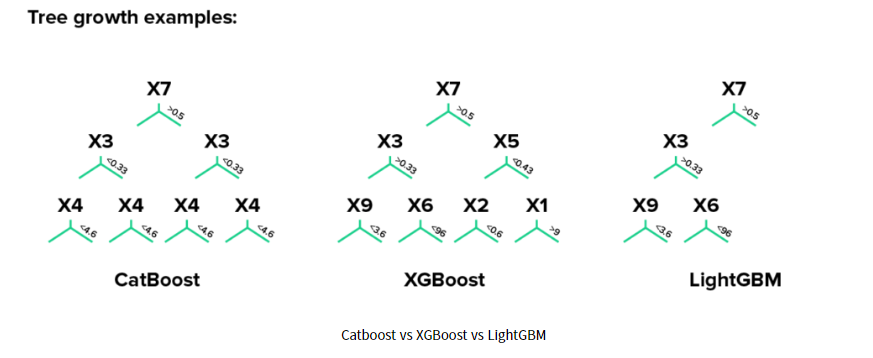

###XGBoost
GBM은 residaul을 줄이는 방향으로 weak learner를 결합해 강력한 성능을 자랑하지만, 해당 train data에 residual을 계속 줄이니까 overfitting 되기 쉽다는 문제점이 있다. 이를 해결하기 위해 XGBoost는 GBM에 regularization term을 추가한 알고리즘이다. 또한 다양한 loss function을 지원해 task에 따른 유연한 튜닝이 가능하다는 장점이 있다.

### Light GBM
부스팅 계열의 대부분 computational cost는 각 단계에서 weak learner인 best tree를 찾는데 쓰인다. 따라서 백만 개의 데이터를 XGBoost로 iteration=1000을 학습시킨 경우, 각 단계에서 tree를 fitting 시키기위해 백만개 데이터를 전부 scan 해야 한다. 해당 과정을 1000번 반복하니 computational cost가 너무 많이 들고 시간이 오래 걸린다. Light GBM은 이러한 높은 cost 문제를 histogram-based/GOSS/EFB 등의 알고리즘을 통해 tree를 구축하기 위한 scan 데이터 양을 줄임으로써 해결한다.

### Catboost

장점
* 대칭 트리 형성 구조 : 예측 시간을 감소
* 비시계열 데이터여도 임의적으로 시계열을 형성해 Boosting을 진행
  * boosting이란 : 머신러닝 앙상블 기법 중 하나로 weak learner들을 여러개 결합해서 예측 및 분류 성능을 높이는 알고리즘
* 전체 데이터를 N개의 Fold로 나누어서 k-fold CV처럼 진행 - 과적합 문제 해결

한계
* sparse matrix에는 부적합 : 추천 시스템 xxx

In [ ]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor
# K Fold 및 기본 데이터 준비 
x_train=df_cat.drop(['운송장_건수'], axis=1, inplace=False)
y_train=df_cat['운송장_건수']


folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 511) 
oof_preds = np.zeros(df_cat.shape[0])

# catboost 이용 
print("using catboost") 
sub_preds_catboost = np.zeros(df_cat_test.shape[0])

using catboost


- K fold의 경우 일정한 간격으로 잘라서 사용, 데이터가 섞이지 못함
- StratifiedKFold는 속성값의 개수를 동일하게 가져가서 데이터가 한곳으로 몰리는 것을 방지함

In [ ]:
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(df_cat, df_cat['운송장_건수'])) : 
    trn_x, trn_y = x_train.iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    #oof_preds_catboost = np.zeros(val_y.shape[0])
    cb_model = CatBoostRegressor(iterations=1000,
                                 learning_rate=0.1,
                                 depth=4,
                                 l2_leaf_reg=20,
                                 bootstrap_type='Bernoulli',
                                 subsample=0.6,
                                 eval_metric='RMSE',
                                 metric_period=50,
                                 od_type='Iter',
                                 od_wait=45,
                                 random_seed=17,
                                 allow_writing_files=False)
    
    cb_model.fit(trn_x, trn_y, eval_set=(val_x, val_y), cat_features=['물품_카테고리'], use_best_model=True, verbose=True)
    
    #oof_preds_catboost[val_idx] = cb_model.predict(val_x)
    sub_preds_catboost += cb_model.predict(df_cat_test) / folds.n_splits

0:	learn: 6.8188888	test: 6.4445104	best: 6.4445104 (0)	total: 69ms	remaining: 1m 8s
50:	learn: 6.6377486	test: 6.2908028	best: 6.2908028 (50)	total: 476ms	remaining: 8.86s
100:	learn: 6.5827872	test: 6.2656556	best: 6.2656556 (100)	total: 876ms	remaining: 7.8s
150:	learn: 6.5286270	test: 6.2503498	best: 6.2474250 (130)	total: 1.55s	remaining: 8.73s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 6.247425028
bestIteration = 130

Shrink model to first 131 iterations.
0:	learn: 6.1634591	test: 8.6910318	best: 8.6910318 (0)	total: 20.2ms	remaining: 20.2s


50:	learn: 6.0655535	test: 8.6137421	best: 8.6135907 (46)	total: 789ms	remaining: 14.7s
100:	learn: 6.0338218	test: 8.5658457	best: 8.5658457 (100)	total: 1.53s	remaining: 13.7s
150:	learn: 6.0096021	test: 8.5407344	best: 8.5404026 (147)	total: 2.21s	remaining: 12.4s
200:	learn: 5.9920960	test: 8.5328177	best: 8.5328177 (200)	total: 2.91s	remaining: 11.6s
250:	learn: 5.9782880	test: 8.5229635	best: 8.5226932 (247)	total: 3.87s	remaining: 11.6s
300:	learn: 5.9553654	test: 8.5018169	best: 8.5012469 (294)	total: 5.01s	remaining: 11.6s
350:	learn: 5.9447665	test: 8.4981920	best: 8.4975318 (347)	total: 5.68s	remaining: 10.5s
400:	learn: 5.9314137	test: 8.4828759	best: 8.4827643 (398)	total: 6.17s	remaining: 9.22s
450:	learn: 5.9217675	test: 8.4805462	best: 8.4769358 (407)	total: 6.72s	remaining: 8.18s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 8.476935769
bestIteration = 407

Shrink model to first 408 iterations.
0:	learn: 6.8731578	test: 6.1923763	best: 6.1923763 (0)

50:	learn: 6.6709165	test: 6.1014790	best: 6.0938107 (41)	total: 773ms	remaining: 14.4s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 6.093810704
bestIteration = 41

Shrink model to first 42 iterations.
0:	learn: 7.0161055	test: 5.5231686	best: 5.5231686 (0)	total: 9.59ms	remaining: 9.58s


50:	learn: 6.8554820	test: 5.4682927	best: 5.4560427 (21)	total: 705ms	remaining: 13.1s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 5.456042736
bestIteration = 21

Shrink model to first 22 iterations.
0:	learn: 6.8172307	test: 6.4430648	best: 6.4430648 (0)	total: 23.1ms	remaining: 23.1s


50:	learn: 6.6712555	test: 6.2119236	best: 6.2119236 (50)	total: 827ms	remaining: 15.4s
100:	learn: 6.6332200	test: 6.1615890	best: 6.1615890 (100)	total: 1.64s	remaining: 14.6s
150:	learn: 6.6134652	test: 6.1450442	best: 6.1450427 (149)	total: 2.14s	remaining: 12s
200:	learn: 6.5942311	test: 6.1338612	best: 6.1317126 (188)	total: 2.81s	remaining: 11.2s
250:	learn: 6.5825551	test: 6.1286331	best: 6.1277060 (240)	total: 3.24s	remaining: 9.66s
300:	learn: 6.5692339	test: 6.1251588	best: 6.1239598 (282)	total: 3.71s	remaining: 8.62s
350:	learn: 6.5578785	test: 6.1174506	best: 6.1172928 (348)	total: 4.3s	remaining: 7.96s
400:	learn: 6.5397831	test: 6.1154245	best: 6.1093978 (355)	total: 4.75s	remaining: 7.1s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 6.109397849
bestIteration = 355

Shrink model to first 356 iterations.


In [ ]:
sub_preds_catboost

array([5.44373783, 5.65467802, 5.85152653, ..., 4.11285451, 4.25377107,
       5.21755963])

In [ ]:
submission=pd.read_csv('/content/drive/MyDrive/DACON/물류 유통량 예측 경진대회/sample_submission.csv')
submission.head()

,index,운송장_건수
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
submission['운송장_건수']=sub_preds_catboost
submission.head()

,index,운송장_건수
0,0,5.443738
1,1,5.654678
2,2,5.851527
3,3,5.454960
4,4,4.521766


# 정답 파일 생성

In [ ]:
submission.to_csv('/content/drive/MyDrive/DACON/물류 유통량 예측 경진대회/catboost.csv', index=False)